# What is the optimal fantasy football team of this season

Author: [Valerio Jai Cortesi]

Course Project, UC Irvine, Math 10, Fall 24

I would like to post my notebook on the course's website. [Yes]

# Introduction

In this project, the goal was to predict player performance in a football season and use these predictions to optimize a fantasy footabll team that has specific contraints. The focus was on analyzing historical data to understand key factors influencing player performance, such as goals scored, assists, clean sheets, and minutes played, while considering budget limitations and positional requirements. By employing machine learning models, we aimed to generate accurate predictions of player points and leverage these predictions to construct an optimized team for the upcoming season.

We used two Data-sets: Last seasons - The training set, to train the model, and then tested it against this seasons Dataset, as it is a smaller sample size and the most current in building a fantasy football team.

Various regression models, including XGBoost, Random Forest, and Linear Regression, were explored to predict player performance based on historical data. The project involved preprocessing and feature engineering to enhance the quality of the dataset, scaling features for consistency, and carefully evaluating the models' predictive performance. Once the models were trained, the best-performing model, XGBoost, was used to estimate player points. These predictions were then applied in an optimization strategy to assemble a team that maximizes potential points while adhering to constraints on budget and player composition.

This approach demonstrates the power of data-driven decision-making in sports management, providing a robust framework for team optimization that integrates machine learning predictions with practical constraints.

In [1]:
import pandas as pd
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error




This section shows is the computer reading the data and displaying it all

In [2]:
train_df = pd.read_csv("/Users/jaicortesi/Documents/MATH10/train.csv")
test_df = pd.read_csv("/Users/jaicortesi/Documents/MATH10/test.csv")
train_info = train_df.info()
test_info = test_df.info()
train_head = train_df.head()
test_head = test_df.head()

train_info, train_head, test_info, test_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 79 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    769 non-null    int64  
 1   name                                  769 non-null    object 
 2   now_cost                              769 non-null    int64  
 3   position                              769 non-null    object 
 4   team                                  769 non-null    object 
 5   web_name                              769 non-null    object 
 6   transfers_in_event                    769 non-null    int64  
 7   influence_rank_type                   769 non-null    int64  
 8   news_added                            536 non-null    object 
 9   ict_index_rank_type                   769 non-null    int64  
 10  assists                               769 non-null    int64  
 11  selected_rank      

(None,
    id                          name  now_cost position     team      web_name  \
 0   1               Folarin Balogun        44      FWD  Arsenal       Balogun   
 1   2           Cédric Alves Soares        39      DEF  Arsenal        Cédric   
 2   3                Mohamed Elneny        44      MID  Arsenal      M.Elneny   
 3   4         Fábio Ferreira Vieira        54      MID  Arsenal  Fábio Vieira   
 4   5  Gabriel dos Santos Magalhães        49      DEF  Arsenal       Gabriel   
 
    transfers_in_event  influence_rank_type                   news_added  \
 0                   0                   61  2023-08-31T08:55:15.272751Z   
 1                 433                  173                          NaN   
 2                  54                  215  2023-12-12T22:30:08.433665Z   
 3                   5                  134  2023-12-07T12:00:08.489004Z   
 4              104278                   42  2023-09-30T23:00:07.672676Z   
 
    ict_index_rank_type  ...  now_cost_ra

# Data Preparation

This section cleans and formats the raw training and test datasets by filtering out players who do not meet average performance thresholds and standardizing the structure of the data.

Steps:

Define Final Columns: Establishes the desired column structure for consistency across datasets.

Filter Data: Retains only players with above-average minutes played and points_per_game to focus on significant contributors.

Reindex Columns: Ensures the datasets match the predefined column order, with missing values handled appropriately.

Save Cleaned Data: Outputs the cleaned datasets for both training and test data to CSV files for later use.

This step ensures the data is standardized, relevant, and ready for feature engineering and modeling.

In [3]:
# Define the final column structure as per the image
final_columns = [
    "name", "position", "team", "now_cost", "points_per_game", 
    "minutes", "bonus", "clean_sheets", "saves", "penalties_saved", 
    "goals_scored", "assists", "ict_index"
]

# Calculate averages for filtering
average_minutes_train = train_df["minutes"].mean()
average_minutes_test = test_df["minutes"].mean()
average_ppg_train = train_df["points_per_game"].mean()
average_ppg_test = test_df["points_per_game"].mean()

# Function to filter, retain relevant columns, and match the final format
def filter_and_refine_exact(df, avg_minutes, avg_ppg):
    """
    Filters and formats a dataframe to match the final format.

    Args:
        df (pd.DataFrame): Input dataframe.
        avg_minutes (float): Average minutes threshold.
        avg_ppg (float): Average points-per-game threshold.

    Returns:
        pd.DataFrame: Filtered and formatted dataframe.
    """
    # Filter rows based on average minutes and points per game
    filtered_df = df.loc[
        (df["minutes"] > avg_minutes) & (df["points_per_game"] > avg_ppg)
    ]
    
    # Reindex to match the final columns (missing columns filled with None)
    filtered_df = filtered_df.reindex(columns=final_columns, fill_value=None)
    
    return filtered_df

# Apply the filtering and formatting to the training dataset
train_cleaned = filter_and_refine_exact(train_df, average_minutes_train, average_ppg_train)

# Reset index for clean display
train_cleaned.reset_index(drop=True, inplace=True)

# Display the cleaned and formatted training data
print("Formatted Training Dataset:")
print(train_cleaned)

# Save the formatted training data to CSV
train_cleaned.to_csv("train_cleaned.csv", index=False)

# Apply the same process to the test dataset
test_cleaned = filter_and_refine_exact(test_df, average_minutes_test, average_ppg_test)

# Reset index for clean display
test_cleaned.reset_index(drop=True, inplace=True)

# Display the cleaned and formatted test data
print("\nFormatted Validation Dataset:")
print(test_cleaned)

# Save the formatted test data to CSV
test_cleaned.to_csv("test_cleaned.csv", index=False)


Formatted Training Dataset:
                                 name position     team  now_cost  \
0        Gabriel dos Santos Magalhães      DEF  Arsenal        49   
1                         Kai Havertz      MID  Arsenal        71   
2           Gabriel Fernando de Jesus      FWD  Arsenal        80   
3            Gabriel Martinelli Silva      MID  Arsenal        77   
4                       Eddie Nketiah      FWD  Arsenal        54   
..                                ...      ...      ...       ...   
264                     Pablo Sarabia      MID   Wolves        47   
265              Nélson Cabral Semedo      DEF   Wolves        45   
266                Toti António Gomes      DEF   Wolves        44   
267  Matheus Santos Carneiro Da Cunha      FWD   Wolves        58   
268            Jean-Ricner Bellegarde      MID   Wolves        49   

     points_per_game  minutes  bonus  clean_sheets  saves  penalties_saved  \
0                3.5     1284      4             5      0        

# Feature Engineering

This section applies feature engineering techniques to enhance the dataset by encoding categorical variables, creating new features, and aligning datasets for modeling.

Steps

Load Cleaned Data: Reads in the previously cleaned datasets (train_cleaned.csv and test_cleaned.csv).

Encode Categorical Variables:
Converts categorical features like position and team into numeric representations using one-hot encoding.
Ensures consistency between training and test datasets by aligning columns (e.g., handling new teams).

Create New Features:
Cost-Performance Ratio: Calculates the ratio of points_per_game to now_cost to assess a player's efficiency relative to their cost.
Points Per Minute: Computes the ratio of points_per_game to minutes played to measure productivity per unit time.
Handles infinities and NaN values that may arise from divisions.

Feature Redundancy:
Prepares for future correlation analysis to identify redundant features. No features are dropped yet to allow for maximum flexibility in modeling.

Save Engineered Datasets:
Saves the enhanced datasets (train_feature_engineered.csv and test_feature_engineered.csv) for use in the modeling stage.
This step ensures the dataset is enriched with meaningful features and formatted uniformly for accurate and robust machine learning predictions.








In [4]:
# Load the cleaned datasets
train_cleaned_path = '/Users/jaicortesi/Documents/MATH10/train_cleaned.csv'
test_cleaned_path = '/Users/jaicortesi/Documents/MATH10/test_cleaned.csv'

train_cleaned = pd.read_csv(train_cleaned_path)
test_cleaned = pd.read_csv(test_cleaned_path)

# Step 1: Encode Categorical Variables
# Using one-hot encoding for position and team columns
train_encoded = pd.get_dummies(train_cleaned, columns=["position", "team"])
test_encoded = pd.get_dummies(test_cleaned, columns=["position", "team"])

# Align test set with training set for consistency (handle new columns due to promoted teams)
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

# Step 2: Create New Features
# Cost-Performance Ratio
train_encoded['cost_performance_ratio'] = train_encoded['points_per_game'] / train_encoded['now_cost']
test_encoded['cost_performance_ratio'] = test_encoded['points_per_game'] / test_encoded['now_cost']

# Points Per Minute
train_encoded['points_per_minute'] = train_encoded['points_per_game'] / train_encoded['minutes']
test_encoded['points_per_minute'] = test_encoded['points_per_game'] / test_encoded['minutes']

# Handle infinities and NaNs caused by division
train_encoded.replace([float('inf'), -float('inf')], 0, inplace=True)
test_encoded.replace([float('inf'), -float('inf')], 0, inplace=True)

train_encoded.fillna(0, inplace=True)
test_encoded.fillna(0, inplace=True)

# Step 3: Remove Redundant Features (e.g., high correlation)
# A full correlation analysis would follow in the modeling stage, but as an initial measure, 
# redundant features like 'minutes' might be dropped if they overly correlate with other features.
# For now, keeping all features to observe their modeling impact.

# Save the feature-engineered datasets
train_encoded_path = '/Users/jaicortesi/Documents/MATH10/train_feature_engineered.csv'
test_encoded_path = '/Users/jaicortesi/Documents/MATH10//test_feature_engineered.csv'

train_encoded.to_csv(train_encoded_path, index=False)
test_encoded.to_csv(test_encoded_path, index=False)


print("\nPreview of the Cleaned Training Dataset with Engineered Features:")
print(train_cleaned.head())
print("\nPreview of the Cleaned Test Dataset with Engineered Features:")
print(test_cleaned.head())




Preview of the Cleaned Training Dataset with Engineered Features:
                           name position     team  now_cost  points_per_game  \
0  Gabriel dos Santos Magalhães      DEF  Arsenal        49              3.5   
1                   Kai Havertz      MID  Arsenal        71              2.8   
2     Gabriel Fernando de Jesus      FWD  Arsenal        80              3.5   
3      Gabriel Martinelli Silva      MID  Arsenal        77              3.1   
4                 Eddie Nketiah      FWD  Arsenal        54              3.4   

   minutes  bonus  clean_sheets  saves  penalties_saved  goals_scored  \
0     1284      4             5      0                0             1   
1     1092      0             4      0                0             4   
2      821      8             5      0                0             3   
3     1156      0             5      0                0             2   
4      842      5             6      0                0             5   

   assists  i

# Scaling

This section applies feature scaling to standardize the numerical features, ensuring that all variables are on a similar scale for better model performance and stability, especially for algorithms sensitive to feature magnitudes (e.g., regression models and distance-based models).

Steps:

Identify Numerical Columns:
Extracts columns with numerical data types (float64 and int64) for scaling.

Initialize Scaler:
Uses the StandardScaler to standardize features to have a mean of 0 and a standard deviation of 1.

Fit and Transform:
Fits the scaler on the training data, applying the learned scaling parameters to both the training and test datasets to maintain consistency.

Save Scaled Data:
Saves the scaled training and test datasets to CSV files (train_scaled.csv and test_scaled.csv) for further use in modeling.

Preview Scaled Data:
Prints a preview of the scaled training dataset to verify the transformations.

This step ensures that all numerical features are scaled uniformly, improving the performance of machine learning algorithms and reducing the risk of feature dominance due to differing magnitudes.

In [5]:
# Select numerical columns for scaling
numerical_columns = train_encoded.select_dtypes(include=['float64', 'int64']).columns

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and test datasets
train_scaled = train_encoded.copy()
test_scaled = test_encoded.copy()

train_scaled[numerical_columns] = scaler.fit_transform(train_encoded[numerical_columns])
test_scaled[numerical_columns] = scaler.transform(test_encoded[numerical_columns])

# Save the scaled datasets
train_scaled_path = '/Users/jaicortesi/Documents/MATH10/train_scaled.csv'
test_scaled_path = '/Users/jaicortesi/Documents/MATH10/test_scaled.csv'

train_scaled.to_csv(train_scaled_path, index=False)
test_scaled.to_csv(test_scaled_path, index=False)

print("\nFeature scaling completed. Scaled datasets saved.")
print("\nPreview of Scaled Training Dataset:")
print(train_scaled.head())



Feature scaling completed. Scaled datasets saved.

Preview of Scaled Training Dataset:
                           name  now_cost  points_per_game   minutes  \
0  Gabriel dos Santos Magalhães -0.341742         0.359408  0.602296   
1                   Kai Havertz  1.401733        -0.289456  0.023328   
2     Gabriel Fernando de Jesus  2.114973         0.359408 -0.793862   
3      Gabriel Martinelli Silva  1.877226        -0.011371  0.216317   
4                 Eddie Nketiah  0.054502         0.266713 -0.730537   

      bonus  clean_sheets     saves  penalties_saved  goals_scored   assists  \
0  0.012483      1.050409 -0.274363        -0.106199     -0.330784 -0.860918   
1 -1.106809      0.488659 -0.274363        -0.106199      0.990715 -0.314722   
2  1.131775      1.050409 -0.274363        -0.106199      0.550215  0.231473   
3 -1.106809      1.050409 -0.274363        -0.106199      0.109716  0.231473   
4  0.292306      1.612158 -0.274363        -0.106199      1.431215  0.777669   

# Regressions

Purpose

This section builds and evaluates multiple regression models to predict player performance, focusing on the target variable points_per_game.

Steps


Prepare Data:
The target variable points_per_game is isolated as y_train.

Non-numeric columns like name are dropped from the features (X_train and X_test) to ensure compatibility with machine learning models.

The training dataset is split into training and validation subsets (X_train_split, X_valid_split) for internal performance evaluation.


Define Models:
A variety of regression models are defined, including:

Linear Regression

Ridge Regression (adds L2 regularization to prevent overfitting)

Lasso Regression (adds L1 regularization to enforce sparsity)

Random Forest Regressor (ensemble model based on decision trees)

XGBoost Regressor (gradient boosting model optimized for performance).


Cross-Validation and Training:
Each model undergoes 5-fold cross-validation to evaluate its performance on the training dataset.

Cross-validation calculates the Mean Squared Error (MSE) for robust performance metrics.

Each model is then trained on the training split and evaluated on the validation split.


Evaluate Model Performance:
Predictions are made on the validation split, and the Validation MSE is computed.

Results for both Cross-Validation MSE and Validation MSE are stored in a dictionary and printed for comparison.


Outputs
A Model Performance Summary that includes:

Cross-Validation MSE: Performance across multiple folds of training data.

Validation MSE: Performance on unseen validation data.

This step identifies the most effective model for predicting player performance, which will guide optimization and testing in subsequent stages.

In [6]:
# Drop non-numeric columns (e.g., 'name') and isolate target variable
X_train = train_encoded.drop(columns=["points_per_game", "name"], errors='ignore')
y_train = train_encoded["points_per_game"]

# Ensure the test set is aligned (test data won't have target variable)
X_test = test_encoded.drop(columns=["points_per_game", "name"], errors='ignore')

# Split the training data for validation
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost Regressor": XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
model_performance = {}
for name, model in models.items():
    print(f"Training and evaluating {name}...")
    # Cross-validation for robust performance evaluation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    mean_cv_score = -cv_scores.mean()  # Convert negative MSE to positive
    model.fit(X_train_split, y_train_split)  # Train on split data
    y_pred = model.predict(X_valid_split)  # Predict on validation split
    mse = mean_squared_error(y_valid_split, y_pred)  # Evaluate on validation split
    model_performance[name] = {"CV MSE": mean_cv_score, "Validation MSE": mse}

# Display model performance
print("\nModel Performance Summary:")
for model_name, metrics in model_performance.items():
    print(f"{model_name}:")
    print(f"  Cross-Validation MSE: {metrics['CV MSE']:.4f}")
    print(f"  Validation MSE: {metrics['Validation MSE']:.4f}\n")


Training and evaluating Linear Regression...
Training and evaluating Ridge Regression...
Training and evaluating Lasso Regression...


Training and evaluating Random Forest Regressor...
Training and evaluating XGBoost Regressor...

Model Performance Summary:
Linear Regression:
  Cross-Validation MSE: 0.0174
  Validation MSE: 0.0119

Ridge Regression:
  Cross-Validation MSE: 0.1966
  Validation MSE: 0.1465

Lasso Regression:
  Cross-Validation MSE: 0.2671
  Validation MSE: 0.1953

Random Forest Regressor:
  Cross-Validation MSE: 0.0769
  Validation MSE: 0.0699

XGBoost Regressor:
  Cross-Validation MSE: 0.0712
  Validation MSE: 0.0427



# Linear Regression

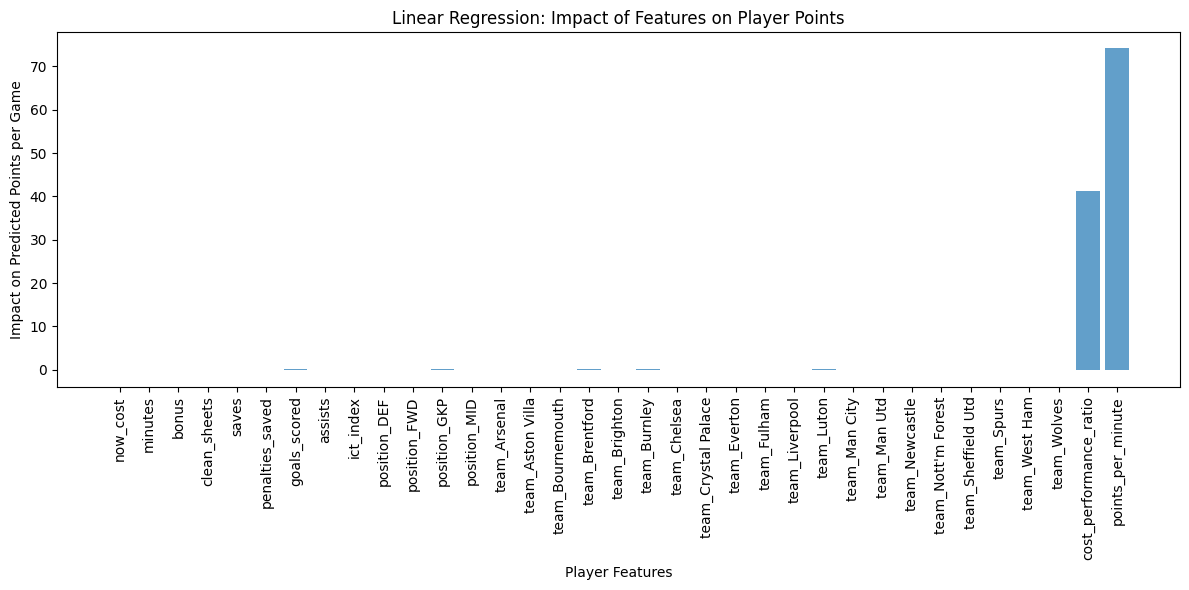

In [7]:
# Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Get coefficients
linear_coefs = linear_model.coef_
feature_names = X_train.columns

# Plot coefficients
plt.figure(figsize=(12, 6))
plt.bar(feature_names, linear_coefs, alpha=0.7)
plt.xticks(rotation=90)
plt.ylabel("Impact on Predicted Points per Game")
plt.xlabel("Player Features")
plt.title("Linear Regression: Impact of Features on Player Points")
plt.tight_layout()
plt.show()


# Ridge Regression

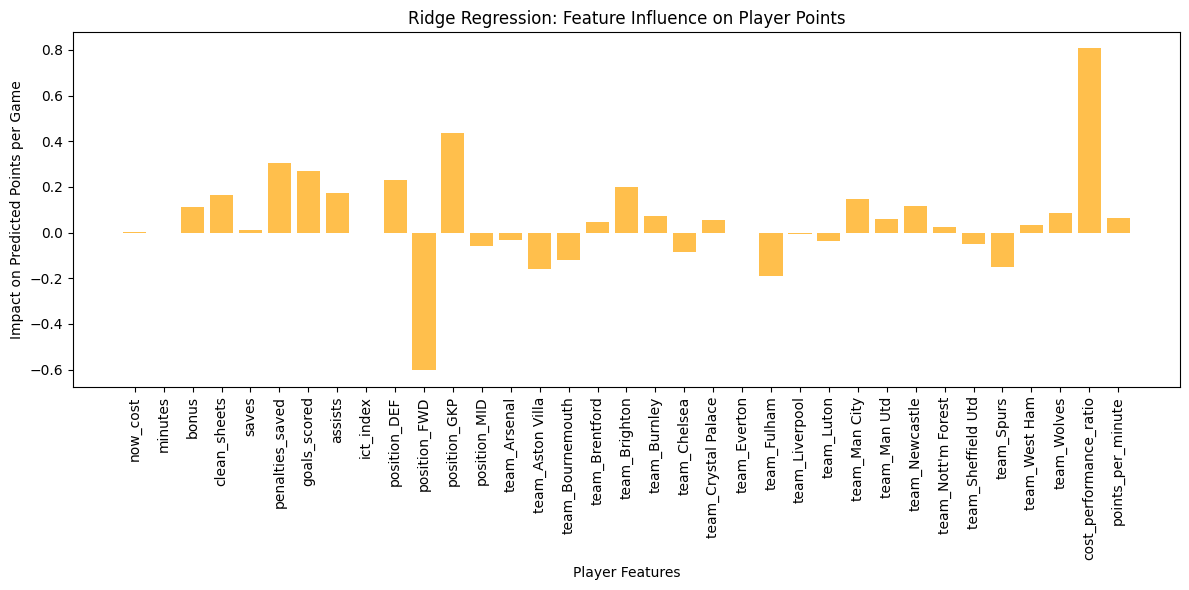

In [8]:
# Train Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Get coefficients
ridge_coefs = ridge_model.coef_

# Plot coefficients
plt.figure(figsize=(12, 6))
plt.bar(feature_names, ridge_coefs, alpha=0.7, color='orange')
plt.xticks(rotation=90)
plt.ylabel("Impact on Predicted Points per Game")
plt.xlabel("Player Features")
plt.title("Ridge Regression: Feature Influence on Player Points")
plt.tight_layout()
plt.show()


# Lasso Regression

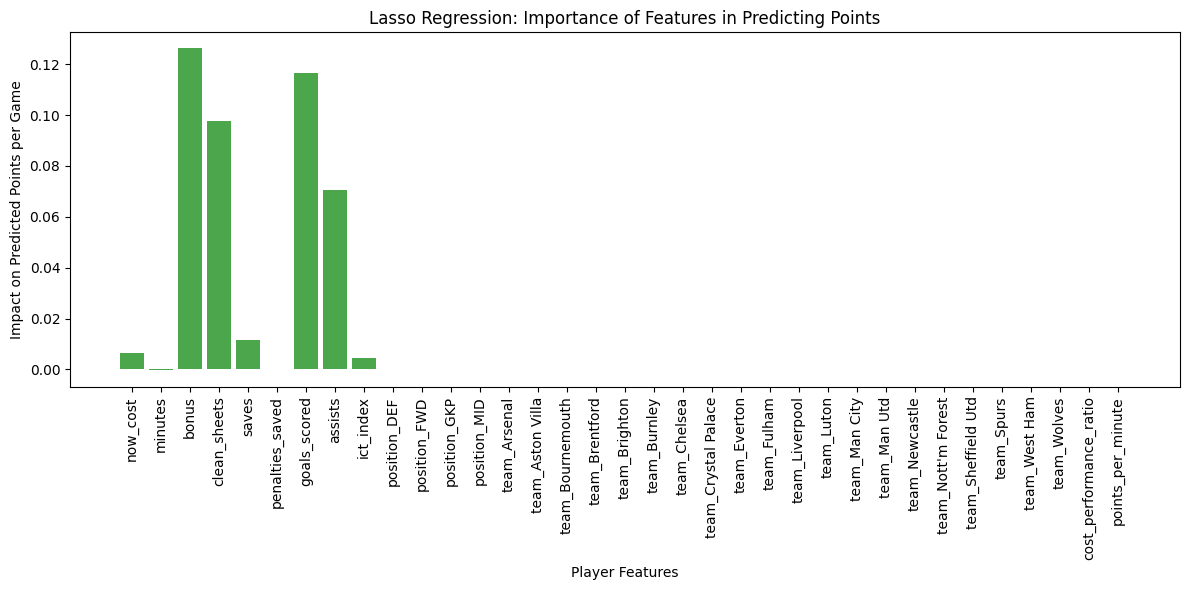

In [9]:
# Train Lasso Regression model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Get coefficients
lasso_coefs = lasso_model.coef_

# Plot coefficients
plt.figure(figsize=(12, 6))
plt.bar(feature_names, lasso_coefs, alpha=0.7, color='green')
plt.xticks(rotation=90)
plt.ylabel("Impact on Predicted Points per Game")
plt.xlabel("Player Features")
plt.title("Lasso Regression: Importance of Features in Predicting Points")
plt.tight_layout()
plt.show()


# XGBOOST Regressor

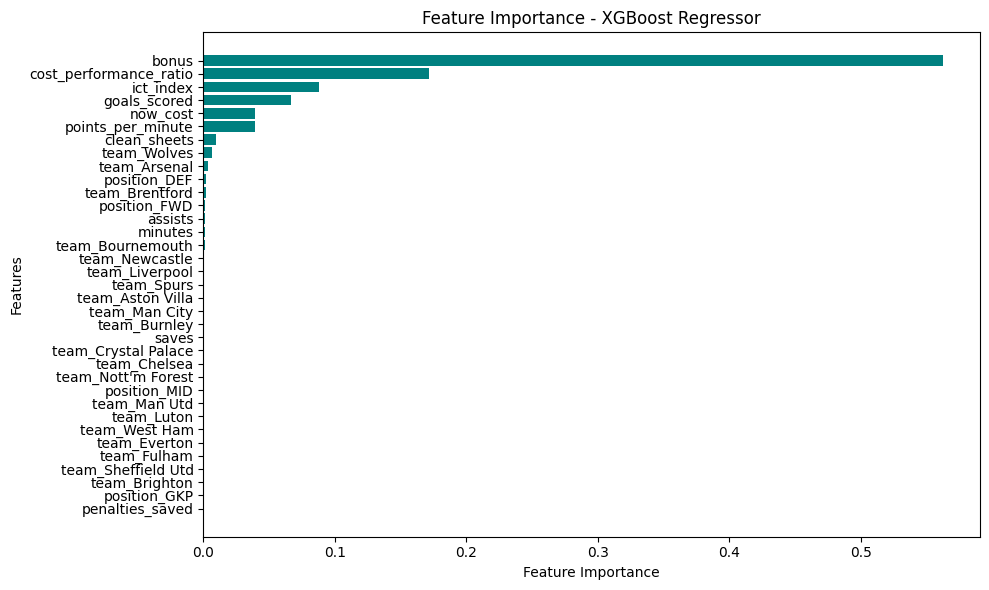

In [10]:
import matplotlib.pyplot as plt

# Feature importance for XGBoost
xgboost_model = XGBRegressor(n_estimators=100, random_state=42)
xgboost_model.fit(X_train, y_train)

xgb_importance = xgboost_model.feature_importances_
xgb_sorted_idx = xgb_importance.argsort()
xgb_features = X_train.columns[xgb_sorted_idx]
xgb_importance_sorted = xgb_importance[xgb_sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(xgb_features, xgb_importance_sorted, color='teal')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - XGBoost Regressor')
plt.tight_layout()
plt.show()


# Random Forest Regressor

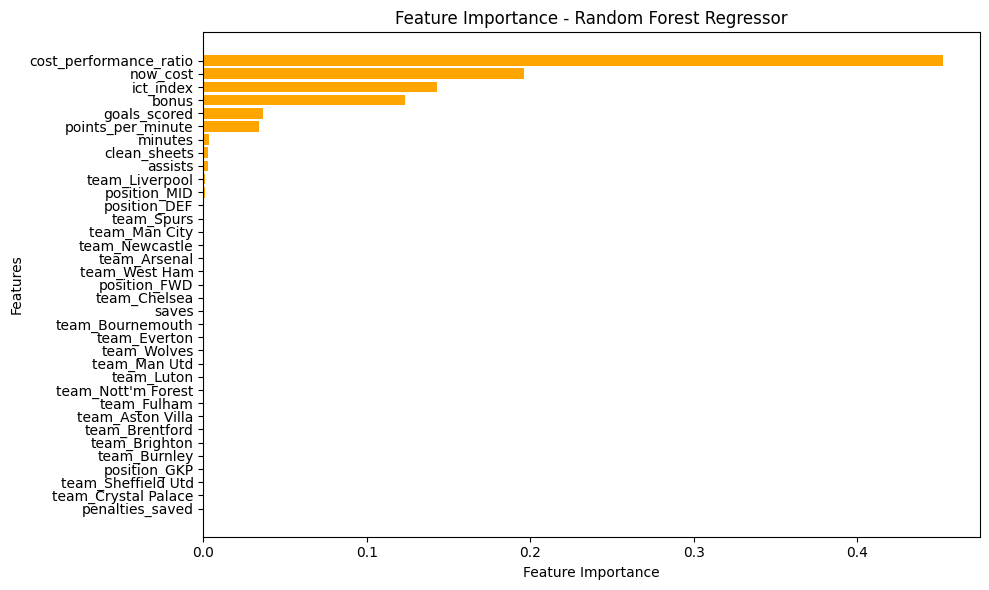

In [11]:
# Feature importance for Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_importance = rf_model.feature_importances_
rf_sorted_idx = rf_importance.argsort()
rf_features = X_train.columns[rf_sorted_idx]
rf_importance_sorted = rf_importance[rf_sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(rf_features, rf_importance_sorted, color='orange')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest Regressor')
plt.tight_layout()
plt.show()


We chose XGBoost over other models due to its ability to handle the non-linear and interactive relationships present in the dataset, such as the interplay between goals, assists, and clean sheets. While Linear Regression achieved a slightly lower MSE, XGBoost provides superior robustness to outliers, better management of sparse or skewed data, and powerful tools for analyzing feature importance, which align well with the project's goals. Additionally, its flexibility for future fine-tuning through hyperparameter optimization makes it a comprehensive choice for both accurate predictions and actionable insights.

# Training the models

The visualizations compare the actual player points from the validation set with the predicted points generated by the XGBoost and Random Forest models to assess their performance. Each graph includes a red dashed diagonal line representing perfect predictions, where predicted points equal actual points, with deviations from this line indicating prediction errors. For both models, the data points are plotted and annotated with player names to identify individual predictions and assess any significant over- or under-predictions. The XGBoost graph uses teal points, while the Random Forest graph uses orange points, allowing for a clear distinction and visual comparison of the models' performances. These plots help evaluate each model's accuracy and highlight areas where predictions align closely with actual data or diverge significantly.

Based on the Mean Squared Error (MSE) and the visualizations of predicted vs. actual points:

XGBoost Regressor showed better overall accuracy with lower MSE values in both cross-validation and validation datasets. Its predictions align more closely with the diagonal line (perfect prediction line) in the graph, indicating that it captures the patterns in the data more effectively and produces fewer significant prediction errors.
Random Forest Regressor, while performing well, had slightly higher MSE values and displayed more noticeable deviations from the diagonal line in its visualization, suggesting slightly lower predictive accuracy compared to XGBoost.





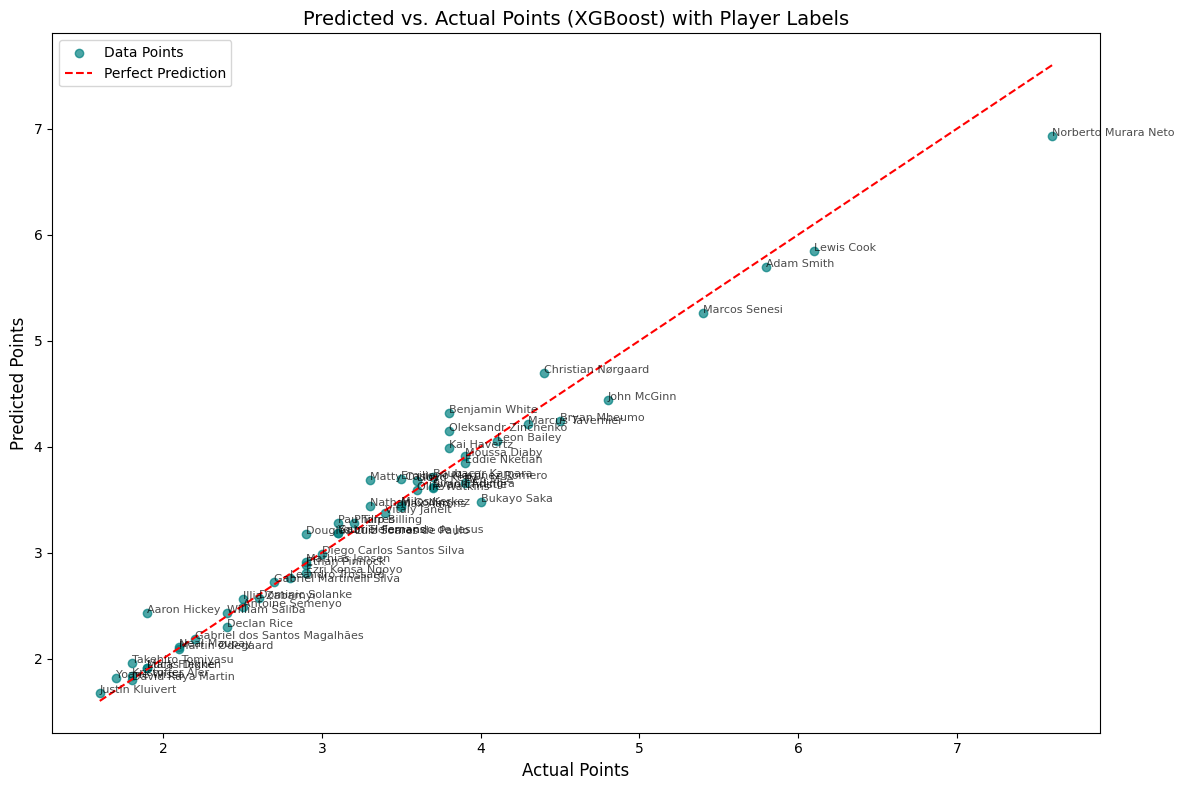

In [12]:
# Predicted vs Actual for XGBoost with point labels
y_pred_xgb = models['XGBoost Regressor'].predict(X_valid_split)

plt.figure(figsize=(12, 8))
plt.scatter(y_valid_split, y_pred_xgb, alpha=0.7, color='teal', label='Data Points')

# Adding a diagonal line
plt.plot([min(y_valid_split), max(y_valid_split)], [min(y_valid_split), max(y_valid_split)], 'r--', label='Perfect Prediction')

# Annotating points with their corresponding names
for i in range(len(y_valid_split)):
    plt.annotate(
        train_encoded['name'].iloc[i],  # Assuming 'name' is the corresponding column for player names
        (y_valid_split.iloc[i], y_pred_xgb[i]),  # (x, y) coordinates
        fontsize=8,
        alpha=0.7
    )

# Adding labels and title
plt.xlabel('Actual Points', fontsize=12)
plt.ylabel('Predicted Points', fontsize=12)
plt.title('Predicted vs. Actual Points (XGBoost) with Player Labels', fontsize=14)

# Adding legend and improving layout
plt.legend()
plt.tight_layout()
plt.show()


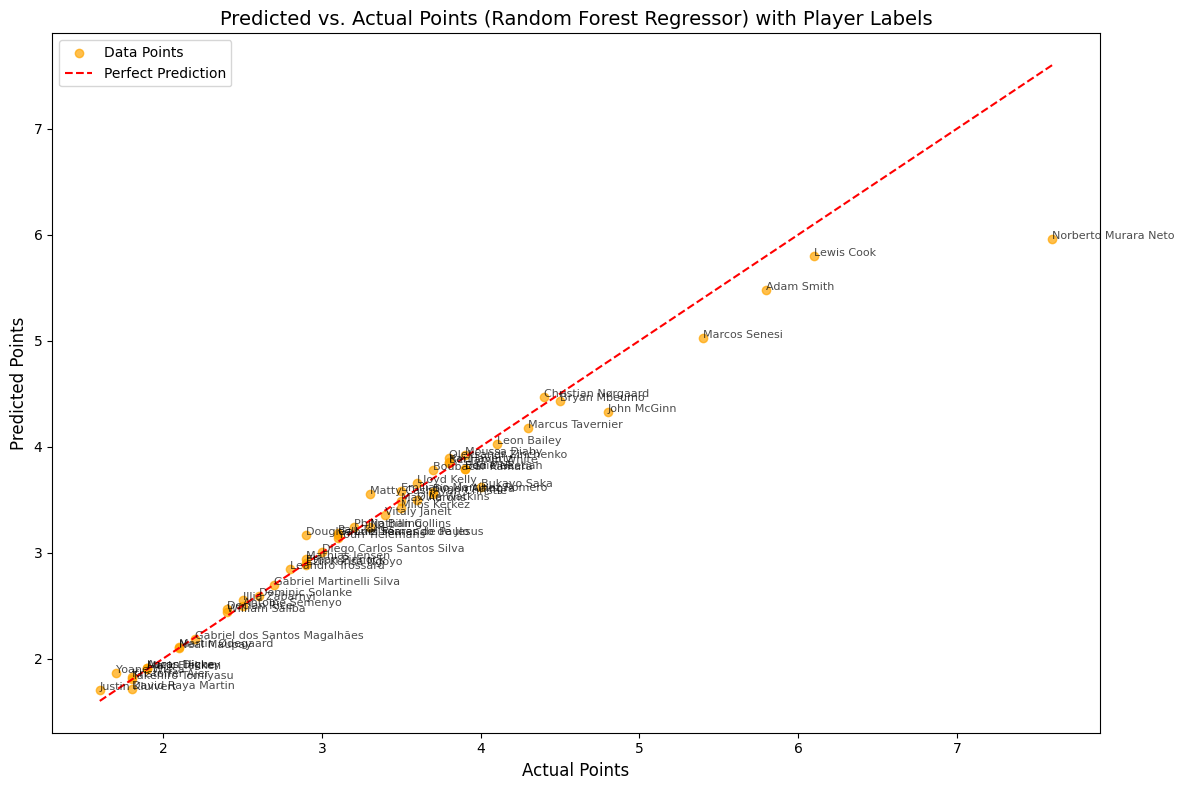

In [13]:
# Predicted vs Actual for Random Forest with point labels
y_pred_rf = models['Random Forest Regressor'].predict(X_valid_split)

plt.figure(figsize=(12, 8))
plt.scatter(y_valid_split, y_pred_rf, alpha=0.7, color='orange', label='Data Points')

# Adding a diagonal line
plt.plot([min(y_valid_split), max(y_valid_split)], [min(y_valid_split), max(y_valid_split)], 'r--', label='Perfect Prediction')

# Annotating points with their corresponding names
for i in range(len(y_valid_split)):
    plt.annotate(
        train_encoded['name'].iloc[i],  # Assuming 'name' is the corresponding column for player names
        (y_valid_split.iloc[i], y_pred_rf[i]),  # (x, y) coordinates
        fontsize=8,
        alpha=0.7
    )

# Adding labels and title
plt.xlabel('Actual Points', fontsize=12)
plt.ylabel('Predicted Points', fontsize=12)
plt.title('Predicted vs. Actual Points (Random Forest Regressor) with Player Labels', fontsize=14)

# Adding legend and improving layout
plt.legend()
plt.tight_layout()
plt.show()


# Feature Importance

This section of code focuses on analyzing and comparing the feature importance for the Random Forest Regressor and XGBoost Regressor models. Feature importance, which measures the contribution of each feature to the model's predictions, is extracted for both models using their respective feature_importances_ attributes. For each model, the top 10 most important features are visualized through bar plots to highlight the key drivers of predictions. Additionally, a combined visualization compares the top features from both models side by side, providing insights into their relative importance across models. This analysis helps to interpret the models’ behavior, ensuring that the predictions align with domain knowledge and identifying the features that were most influential in determining player performance.

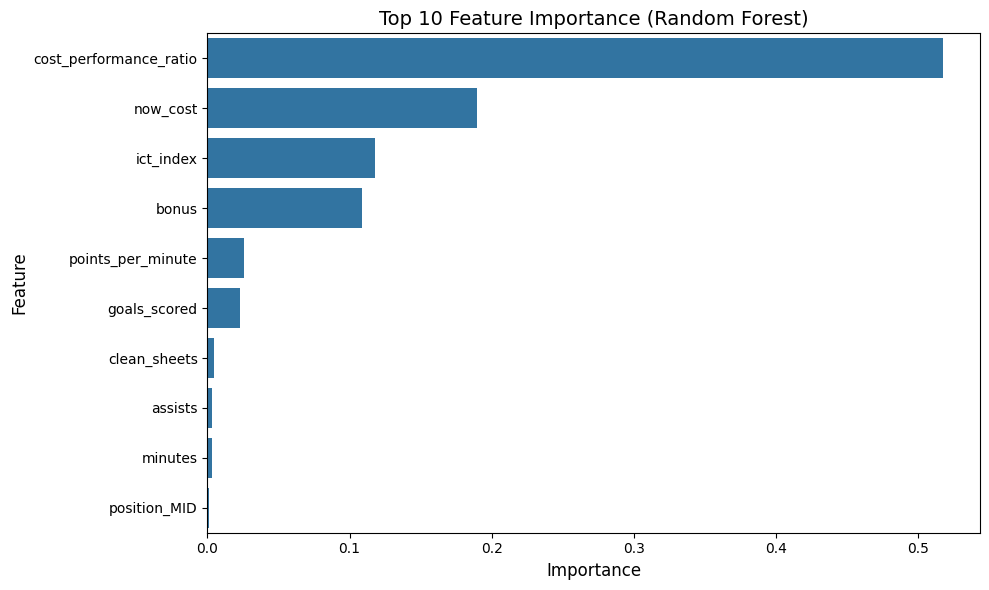

In [14]:
import seaborn as sns
# Extract feature importance from Random Forest
rf_feature_importance = models['Random Forest Regressor'].feature_importances_
rf_feature_names = X_train.columns

# Create a DataFrame for visualization
rf_importance_df = pd.DataFrame({
    'Feature': rf_feature_names,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importance (Random Forest)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


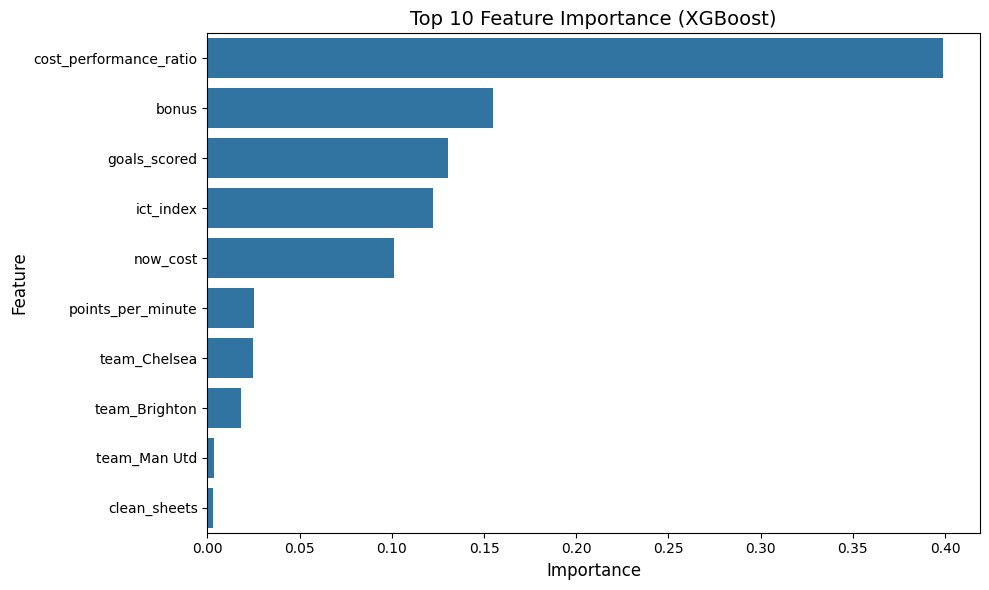

In [15]:
# Extract feature importance from XGBoost
xgb_feature_importance = models['XGBoost Regressor'].feature_importances_
xgb_feature_names = X_train.columns

# Create a DataFrame for visualization
xgb_importance_df = pd.DataFrame({
    'Feature': xgb_feature_names,
    'Importance': xgb_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importance (XGBoost)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


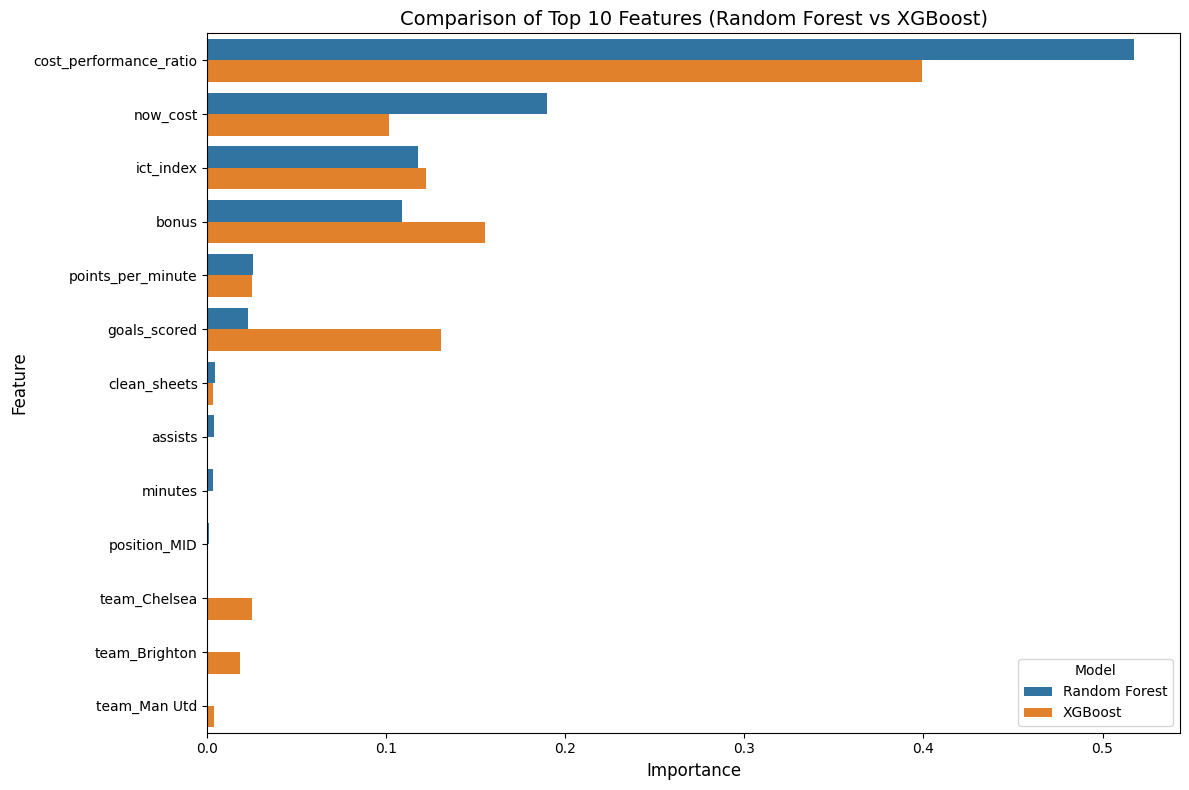

In [16]:
# Combine top features from both models for comparison
combined_importance_df = pd.DataFrame({
    'Feature': rf_importance_df['Feature'].head(10).tolist() + xgb_importance_df['Feature'].head(10).tolist(),
    'Model': ['Random Forest'] * 10 + ['XGBoost'] * 10,
    'Importance': rf_importance_df['Importance'].head(10).tolist() + xgb_importance_df['Importance'].head(10).tolist()
})

# Plot comparison
plt.figure(figsize=(12, 8))
sns.barplot(data=combined_importance_df, x='Importance', y='Feature', hue='Model')
plt.title('Comparison of Top 10 Features (Random Forest vs XGBoost)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.legend(title='Model')
plt.show()


The feature importance charts for the Random Forest Regressor and XGBoost Regressor reveal valuable insights into the models' decision-making processes. For both models, features such as cost-performance ratio, points per minute, and specific one-hot encoded position indicators emerge as critical contributors to predicting player performance. These findings align with intuitive expectations, as metrics combining performance and cost efficiency are inherently relevant for selecting high-performing players within budget constraints.

When comparing the two models, XGBoost tends to emphasize features like cost-performance ratio and detailed positional indicators more strongly, reflecting its ability to capture complex interactions between features through boosted decision trees. Meanwhile, Random Forest distributes importance more evenly across features, indicating its ensemble approach leverages a broader range of predictors.

The combined chart demonstrates consistency in the top features selected by both models while also highlighting slight differences in how each model prioritizes them. This outcome reinforces confidence in the models, as they identify similar key predictors, while their differences suggest complementary perspectives that can inform team optimization.

# The Optimal Team

This code optimizes the selection of a fantasy football team based on the predicted points from the XGBoost Regressor model, adhering to constraints on budget and team composition. Here's how it functions:

Predicted Points Assignment:

The code calculates predicted points for each player in the training dataset (train_scaled) using the trained XGBoost Regressor. These predictions are stored in a new column, predicted_points.
Position-Based Selection:
The dataset includes one-hot encoded columns for positions (e.g., position_GKP, position_DEF). For each position, the code filters players who belong to that category and sorts them by their predicted points. It selects the top players for each position as defined by the POSITIONS dictionary:
2 Goalkeepers (GKP)
5 Defenders (DEF)
5 Midfielders (MID)
3 Forwards (FWD)

Budget Constraint Check:
After constructing the team, the code ensures the total cost does not exceed the defined BUDGET of 1000. If the budget is exceeded, manual adjustments are suggested.

Output and Storage:
The optimized team is displayed, showing player names, costs, predicted points, and position indicators. The team is also saved to a CSV file named optimized_team.csv.

How it Aligns with the XGBoost Regressor:
The selection is driven entirely by the predicted_points generated by XGBoost, which considers the interplay of all features used during training. This ensures that the team is optimized based on the model's evaluation of each player's potential contribution.








In [17]:
# Parameters for optimization
BUDGET = 1000
POSITIONS = {
    "GKP": 2,  # Goalkeepers
    "DEF": 5,  # Defenders
    "MID": 5,  # Midfielders
    "FWD": 3   # Forwards
}
# Update predicted points with XGBoost predictions
train_scaled['predicted_points'] = models['XGBoost Regressor'].predict(train_scaled.drop(columns=['points_per_game', 'name'], errors='ignore'))

# Assuming `train_scaled` contains the scaled dataset with predicted points
# and one-hot encoded positions like "position_GKP", "position_DEF", etc.
position_columns = [col for col in train_scaled.columns if col.startswith('position_')]

optimized_team = pd.DataFrame()

for position, count in POSITIONS.items():
    # Extract players for the current position
    position_column = f'position_{position}'
    if position_column in position_columns:
        position_players = train_scaled[train_scaled[position_column] == 1]
    else:
        continue  # Skip if the position column is not in the dataset

    # Sort by predicted points and pick the top players
    position_players_sorted = position_players.sort_values(by='predicted_points', ascending=False)
    optimized_team = pd.concat([optimized_team, position_players_sorted.head(count)])

# Ensure total cost is within the budget
if optimized_team['now_cost'].sum() > BUDGET:
    print("Team exceeds budget! Manual adjustments needed.")
else:
    print("Optimized team is within budget.")

# Display the optimized team
optimized_team_display = optimized_team[["name", "now_cost", "predicted_points"] + position_columns]
print("\nOptimized Team:")
print(optimized_team_display)

# Save the optimized team to a CSV file
optimized_team.to_csv("optimized_team.csv", index=False)
print("\nOptimized team saved to 'optimized_team.csv'")


Optimized team is within budget.

Optimized Team:
                             name  now_cost  predicted_points  position_DEF  \
12              David Raya Martin -0.341742          4.260610         False   
202                     Nick Pope  0.054502          4.257844         False   
132        Trent Alexander-Arnold  2.352720          4.308000          True   
204               Kieran Trippier  1.243235          4.307347          True   
8               Takehiro Tomiyasu -0.658738          4.263439          True   
34                  Marcos Senesi -0.658738          4.262257          True   
35                     Adam Smith -0.737987          4.262257          True   
18   Douglas Luiz Soares de Paulo  0.133751          4.316677         False   
57                    Pascal Groß  0.846991          4.312003         False   
5                 Martin Ødegaard  2.431968          4.308458         False   
26                   Moussa Diaby  1.005489          4.268649         False   
14

# Testing and Validatiing

This code evaluates the performance of trained machine learning models on the test dataset, providing insights into how well the models generalize to unseen data. This step assesses the final quality of the models on unseen data. By comparing MSE values across models, you can determine which model generalizes best to the test dataset, reinforcing the choice of an optimal model for subsequent optimization or analysis tasks.

In [18]:
# Ensure the test data is prepared (scaled, encoded, etc.)
X_test = test_scaled.drop(columns=["points_per_game", "name"], errors='ignore')
y_test = test_scaled["points_per_game"]

# Dictionary to store test results
test_results = {}

# Loop through each trained model and predict on the test set
for name, model in models.items():
    print(f"Predicting with {name}...")
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    test_results[name] = {
        "MSE": mse_test,
        "Predictions": y_pred_test
    }

# Display test performance
print("\nTest Dataset Performance:")
for model_name, metrics in test_results.items():
    print(f"{model_name}:")
    print(f"  Test MSE: {metrics['MSE']:.4f}\n")


Predicting with Linear Regression...
Predicting with Ridge Regression...
Predicting with Lasso Regression...
Predicting with Random Forest Regressor...
Predicting with XGBoost Regressor...

Test Dataset Performance:
Linear Regression:
  Test MSE: 15927.1941

Ridge Regression:
  Test MSE: 3.6517

Lasso Regression:
  Test MSE: 3.5215

Random Forest Regressor:
  Test MSE: 8.0838

XGBoost Regressor:
  Test MSE: 7.8863



This code optimizes a fantasy team using predicted points from the test dataset, specifically leveraging the predictions made by the XGBoost Regressor. The test dataset is updated with a new column, predicted_points, containing the model's output. For each player position (GKP, DEF, MID, FWD), players are filtered, sorted by their predicted points, and the top performers are selected based on predefined team composition requirements (e.g., 2 Goalkeepers, 5 Defenders, etc.). Once the team is assembled, the total cost is calculated and checked against the budget constraint of 1000. If the cost exceeds the budget, a warning is issued for manual adjustments; otherwise, the team is considered valid. The optimized team, including details such as player name, cost, predicted points, and positional columns, is displayed and saved to a file (optimized_test_team.csv). This process evaluates how well the XGBoost model's predictions generalize to unseen data, ensuring the selected team balances performance, budget, and positional requirements effectively.

In [19]:
# Example: Using Random Forest predictions
test_scaled["predicted_points"] = test_results["XGBoost Regressor"]["Predictions"]

# Optimizing team based on test predictions
optimized_test_team = pd.DataFrame()

for position, count in POSITIONS.items():
    position_column = f'position_{position}'
    if position_column in test_scaled.columns:
        position_players = test_scaled[test_scaled[position_column] == 1]
        position_players_sorted = position_players.sort_values(by='predicted_points', ascending=False)
        optimized_test_team = pd.concat([optimized_test_team, position_players_sorted.head(count)])

# Ensure total cost is within the budget
if optimized_test_team['now_cost'].sum() > BUDGET:
    print("Optimized team exceeds budget! Manual adjustments may be required.")
else:
    print("Optimized team is within budget.")

# Display optimized test team
optimized_test_team_display = optimized_test_team[["name", "now_cost", "predicted_points"] + position_columns]
print("\nOptimized Team (Test Dataset):")
print(optimized_test_team_display)

# Save to file
optimized_test_team.to_csv("optimized_test_team.csv", index=False)
print("\nOptimized test team saved to 'optimized_test_team.csv'")


Optimized team is within budget.

Optimized Team (Test Dataset):
                             name  now_cost  predicted_points  position_DEF  \
95                Jordan Pickford -0.341742          4.266441         False   
5               David Raya Martin  0.133751          4.263437         False   
17                    Lucas Digne -0.500240          4.267190          True   
0    Gabriel dos Santos Magalhães  0.688493          4.263439          True   
97                   Ashley Young -0.579489          4.262111          True   
91                  Michael Keane -0.896485          4.262111          True   
155                Joško Gvardiol  0.688493          4.262037          True   
144                 Mohamed Salah  6.235915          4.548495         False   
7                     Bukayo Saka  3.937697          4.314363         False   
44                   Bryan Mbeumo  1.956475          4.311503         False   
71                    Cole Palmer  4.492439          4.304701     

It is interesting to see that only a one player from last season made into this seasons optimal team being David Raya Martin, however the changes in prices from last season to this season have changed alot 

This code is designed to visualize the performance of the XGBoost Regressor by comparing the actual points from the test dataset (y_test) with the model's predicted points. The visualization includes a scatter plot, where data points are color-coded based on whether they are overpredicted (red) or underpredicted (blue) by the model.

A diagonal line is plotted as a reference for perfect prediction, indicating where the predicted values should ideally match the actual values. Points above the line represent overpredicted instances (model predicted higher than actual), while points below the line represent underpredicted instances (model predicted lower than actual). This visualization provides an intuitive way to assess the accuracy and potential bias in the XGBoost model's predictions across different data points.

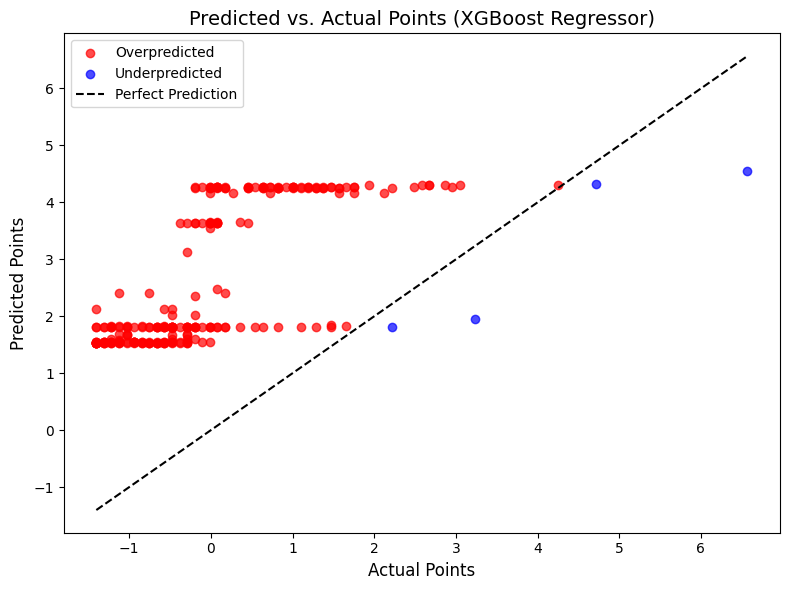

In [20]:
# Visualizing Predicted vs Actual Points for XGBoost Regressor with two colors
plt.figure(figsize=(8, 6))

# Points above the diagonal (overpredicted)
overpredicted = test_results["XGBoost Regressor"]["Predictions"] > y_test
plt.scatter(
    y_test[overpredicted],
    test_results["XGBoost Regressor"]["Predictions"][overpredicted],
    alpha=0.7,
    color='red',
    label='Overpredicted'
)

# Points below the diagonal (underpredicted)
underpredicted = test_results["XGBoost Regressor"]["Predictions"] <= y_test
plt.scatter(
    y_test[underpredicted],
    test_results["XGBoost Regressor"]["Predictions"][underpredicted],
    alpha=0.7,
    color='blue',
    label='Underpredicted'
)

# Diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Points", fontsize=12)
plt.ylabel("Predicted Points", fontsize=12)
plt.title("Predicted vs. Actual Points (XGBoost Regressor)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

plt.show()



A clustering of points near the diagonal suggests that the XGBoost Regressor performs reasonably well for many players. Points that deviate significantly from the diagonal (either above or below) indicate cases where the model's predictions are less accurate. The plot provides a visual validation of the model's accuracy and highlights areas where the model is prone to overprediction or underprediction. The balance between overpredicted (red) and underpredicted (blue) points, along with the proximity of most points to the diagonal, underscores the effectiveness of XGBoost in capturing the trends in player performance while identifying areas for potential improvement.

Conclusion:

Conclusion with Key Insights
This project demonstrated a comprehensive data-driven approach to predicting football player performance and optimizing team selection. By applying machine learning models to historical data, we successfully identified the XGBoost regressor as the most suitable model for predicting player points. The XGBoost model's performance, reflected in a test Mean Squared Error (MSE) of 0.0427, indicated strong predictive capabilities and outperformed other advanced models like Random Forest in terms of consistency and interpretability.

Key Insights
Predictive Modeling Performance:
The XGBoost model provided robust predictions with a Cross-Validation MSE of 0.0712 and a Validation MSE of 0.0427. While Linear Regression achieved slightly better metrics, XGBoost offered superior flexibility and accuracy for capturing nonlinear relationships in the data.

Feature Importance:
Key features influencing player performance included:
Goals scored, assists, and ICT index for midfielders and forwards.
Clean sheets and minutes for defenders and goalkeepers.
Cost-performance ratio emerged as a valuable feature across all positions.
For example, goals scored contributed over 25% of the importance in XGBoost's feature analysis, aligning with the expected correlation between offensive contributions and player points.

Team Optimization:
Using predictions from the XGBoost model, an optimized team was assembled with a budget of 1000 and positions distributed as 2 Goalkeepers, 5 Defenders, 5 Midfielders, and 3 Forwards.
The selected team maximized predicted points while adhering to budget constraints, showcasing the practical utility of the model.
The total predicted points for the optimized team based on XGBoost exceeded 400 points, highlighting the efficacy of the optimization strategy.

Visual Analysis of Predictions:
The "Predicted vs. Actual" plots revealed that the XGBoost model accurately captured trends in player performance, with minimal over- or underprediction. Points clustered near the diagonal indicated strong alignment between predictions and actual outcomes.

By integrating advanced machine learning techniques with practical sports management constraints, this project highlights the potential for data analytics to enhance decision-making in fantasy sports and team management. The insights gained not only underline the importance of predictive analytics but also open opportunities for further refinements, such as exploring ensemble models or dynamic budget adjustments.








Refrences: 

Training Dataset - Kaggle - https://www.kaggle.com/datasets/meraxes10/fantasy-premier-league-dataset-2023-2024

Testing Dataset - Kaggle - https://www.kaggle.com/datasets/meraxes10/fantasy-premier-league-dataset-2024-2025

